In [1]:
#Download helping functions
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

NameError: name 'os' is not defined

In [2]:
#Import necessary libraries
import os
import torch
import csv
import utils
import pandas as pd
import numpy as np
from PIL import Image
from scipy.ndimage import label
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torch.utils.data import Dataset, DataLoader
df = pd.read_csv('data/train.csv')

In [3]:
#Helping function
def separate_defects(mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
    labeled_mask, num_features = label(mask)
    individual_masks = []
    for i in range(1, num_features + 1):
        individual_mask = np.zeros_like(mask, dtype=np.uint8)
        individual_mask[labeled_mask == i] = 1
        individual_masks.append(individual_mask)
    
    if len(individual_masks) == 0:
        return torch.empty((0, mask.shape[0], mask.shape[1]), dtype=torch.uint8)
    
    individual_masks = np.stack(individual_masks)
    return torch.tensor(individual_masks, dtype=torch.uint8).clone().detach()
    
def rle_to_mask(lre, shape=(1600,256)):
    '''
    params:  rle   - run-length encoding string (pairs of start & length of encoding)
             shape - (width,height) of numpy array to return 
    
    returns: numpy array with dimensions of shape parameter
    '''    
    # the incoming string is space-delimited
    runs = np.asarray([int(run) for run in lre.split(' ')])
    
    # we do the same operation with the even and uneven elements, but this time with addition
    runs[1::2] += runs[0::2]
    # pixel numbers start at 1, indexes start at 0
    runs -= 1
    
    # extract the starting and ending indeces at even and uneven intervals, respectively
    run_starts, run_ends = runs[0::2], runs[1::2]
    
    # build the mask
    h, w = shape
    mask = np.zeros(h*w, dtype=np.uint8)
    for start, end in zip(run_starts, run_ends):
        mask[start:end] = 1
    
    # transform the numpy array from flat to the original image shape
    return mask.reshape(shape).T

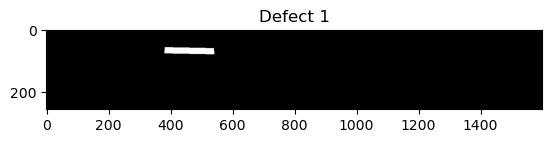

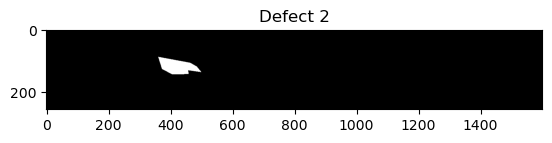

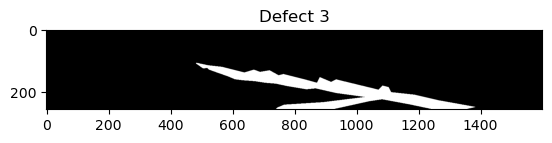

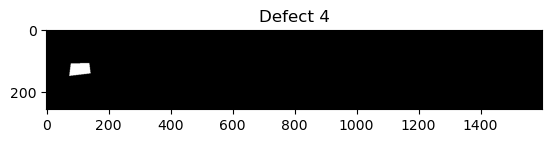

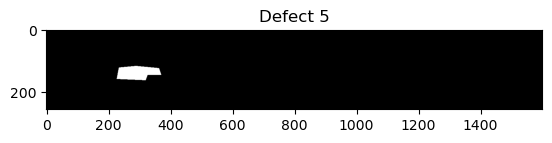

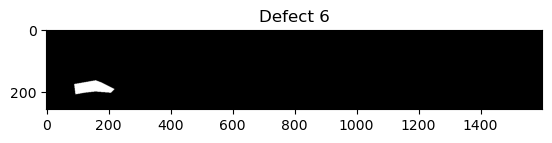

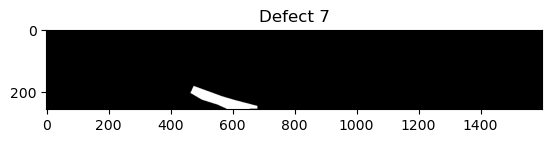

In [4]:
#Visualizing the mask seperation
mask_image_path = 'data/train_masks/0a26aceb2.jpg_mask.png'
mask_image = Image.open(mask_image_path).convert('L')  # Convert to grayscale
mask = np.array(mask_image)
individual_masks = separate_defects(mask)
# Visualize the individual masks
for i, im in enumerate(individual_masks):
    plt.imshow(im, cmap='gray')
    plt.title(f'Defect {i+1}')
    plt.show()

In [5]:
#Custom dataset for working with the data
class SeverstalSteelDataset(Dataset):
    def __init__(self, root, csv_file, transforms, mode='train'):
        self.root = root
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.category = []
        self.transforms = transforms
        self.df = df
   
        with open(csv_file, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(row['ImageId'])
                if mode != 'test':
                    self.category.append(int(row['ClassId'])-1)
        if mode == 'train':
            self.data_list = self.data_list[0:6000]
            self.category = self.category[0:6000]
        if mode == 'val':
            self.data_list = self.data_list[6000:7096]
            self.category = self.category[6000:7096] 

    def __getitem__(self, idx):
        #load images and masks
        img_path = os.path.join("data/train_images", self.data_list[idx])
        img = read_image(img_path)
        mask = rle_to_mask(self.df['EncodedPixels'][idx])
        #Seperate the defects
        masks = separate_defects(mask).squeeze(1)
        masks = torch.tensor(masks, dtype=torch.uint8)
        num_objs = masks.size(dim=0)
        
        if masks.numel() == 0 or torch.sum(masks) == 0:
            masks = torch.zeros((1,256,1600), dtype=torch.float32)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((num_objs,), dtype=torch.int64)
        else:
            boxes = masks_to_boxes(masks)
            # Remove invalid boxes
            valid_boxes = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
            boxes = boxes[valid_boxes]
            masks = masks[valid_boxes]
            num_objs = boxes.size(0)
            labels = torch.ones((num_objs,), dtype=torch.int64)
            
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img,target = self.transforms(img,target)

        return img, target

    def __len__(self):
        return len(self.data_list)

In [6]:
from torchvision.models import convnext_small, ConvNeXt_Small_Weights

def get_convnext_backbone():
    # Load the pre-trained ConvNeXt model
    convnext = convnext_small(weights=ConvNeXt_Small_Weights.DEFAULT)
    
    # Remove the classification head
    backbone = torch.nn.Sequential(*(list(convnext.children())[:-2]))
    
    # Get the number of output channels
    backbone.out_channels = 768
    
    return backbone

In [7]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = get_convnext_backbone()
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 768

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
last_model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [8]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms_list = []
    transforms_list.append(T.Resize((64, 400)))  
    if train:
        transforms_list.append(T.RandomHorizontalFlip(0.5))
        transforms_list.append(T.RandomVerticalFlip(0.5))
    transforms_list.append(T.ToDtype(torch.float, scale=True))
    transforms_list.append(T.ToPureTensor())
    transforms_list.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return T.Compose(transforms_list)

/tmp/ipykernel_26262/1763515476.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(masks, dtype=torch.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


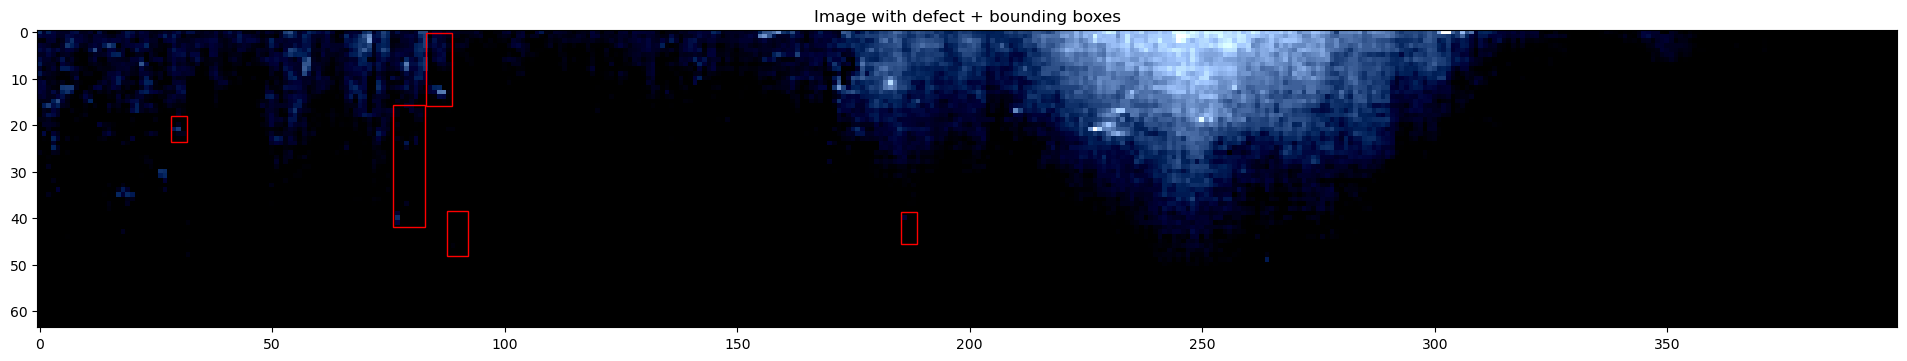

In [9]:
#Visualizing a sample after normalizing + bounding box 
def show_image_with_boxes(img, target):
    # Convert image tensor to numpy array
    img = img.permute(1, 2, 0).cpu().numpy()

    # Create a figure
    fig, ax = plt.subplots(1, figsize=(24, 12))

    # Display the image with bounding boxes
    ax.imshow(img)
    boxes = target['boxes'].cpu().numpy()
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.set_title('Image with defect + bounding boxes')

    plt.show()

# Load a sample from the dataset
dataset = SeverstalSteelDataset('data', 'data/train.csv', transforms=get_transform(train=True))
img, target = dataset[0]  # Change the index if you want to see a different sample

# Show the image with bounding boxes
show_image_with_boxes(img, target)


In [10]:
#Defining the training function
import math

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None, accumulation_steps=32):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    optimizer.zero_grad()  # Ensure gradients are zeroed before starting
    for i, (images, targets) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        if scaler is not None:
            scaler.scale(losses).backward()
        else:
            losses.backward()

        if (i + 1) % accumulation_steps == 0:
            if scaler is not None:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            
            optimizer.zero_grad()
        
        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    # Update remaining gradients if not perfectly divisible
    if (i + 1) % accumulation_steps != 0:
        if scaler is not None:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()
        
        optimizer.zero_grad()

    return metric_logger


In [11]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Defect + background
num_classes = 2
# use our dataset and defined transformations
dataset = SeverstalSteelDataset('data', 'data/train.csv', transforms = get_transform(train=True), mode='train')
dataset_test = SeverstalSteelDataset('data', 'data/train.csv', transforms = get_transform(train=False), mode='val')

In [12]:
from engine import evaluate
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=4,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = last_model

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params,
    lr=0.001,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 5
effective_batch_size = 128
mini_batch_size = 8  # Same as the DataLoader batch size
accumulation_steps = effective_batch_size / mini_batch_size

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    
    lr_scheduler.step()

print("That's it!")

/tmp/ipykernel_26262/1763515476.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks = torch.tensor(masks, dtype=torch.uint8)
/home/duc/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: [0]  [   0/1500]  eta: 0:20:17  lr: 0.000002  loss: 1.4906 (1.4906)  loss_classifier: 0.6977 (0.6977)  loss_box_reg: 0.0070 (0.0070)  loss_objectness: 0.6951 (0.6951)  loss_rpn_box_reg: 0.0908 (0.0908)  time: 0.8120  data: 0.0513  max mem: 5178
Epoch: [0]  [  10/1500]  eta: 0:11:10  lr: 0.000012  loss: 1.4475 (1.4599)  loss_classifier: 0.6962 (0.6974)  loss_box_reg: 0.0121 (0.0157)  loss_objectness: 0.6955 (0.6956)  loss_rpn_box_reg: 0.0305 (0.0512)  time: 0.4500  data: 0.0421  max mem: 5537
Epoch: [0]  [  20/1500]  eta: 0:10:58  lr: 0.000022  loss: 1.4475 (1.4574)  loss_classifier: 0.6987 (0.6985)  loss_box_reg: 0.0094 (0.0153)  loss_objectness: 0.6957 (0.6956)  loss_rpn_box_reg: 0.0383 (0.0479)  time: 0.4264  data: 0.0413  max mem: 5537
Epoch: [0]  [  30/1500]  eta: 0:11:16  lr: 0.000032  loss: 1.4548 (1.4578)  loss_classifier: 0.6990 (0.6985)  loss_box_reg: 0.0106 (0.0168)  loss_objectness: 0.6959 (0.6957)  loss_rpn_box_reg: 0.0405 (0.0467)  time: 0.4659  data: 0.0410  max me

In [13]:
model = last_model
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (

In [14]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.ToTensor(),
        T.ConvertImageDtype(torch.float),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image)
    return image

In [15]:
def reverse_normalize_and_convert(img, mean, std, device):
    mean = torch.tensor(mean).view(3, 1, 1).to(device)
    std = torch.tensor(std).view(3, 1, 1).to(device)
    img = img * std + mean  # Reverse normalization
    img = torch.clamp(img, 0, 1)  # Ensure the values are within [0, 1]
    img = img * 255  # Scale values to [0, 255]
    img = img.to(torch.uint8)  # Convert to uint8
    return img

In [20]:
def visualize_predictions(image, predictions, device):
    # Reverse normalization for visualization
    image = reverse_normalize_and_convert(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], device=device).permute(1, 2, 0).cpu().numpy()
    
    # Create a figure
    fig, ax = plt.subplots(1, figsize=(24, 12))

    # Display the image with bounding boxes
    ax.imshow(image)
    boxes = predictions['boxes'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f"defect", color='yellow', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    ax.set_title('Predicted bounding boxes of potential defects')

    plt.show()

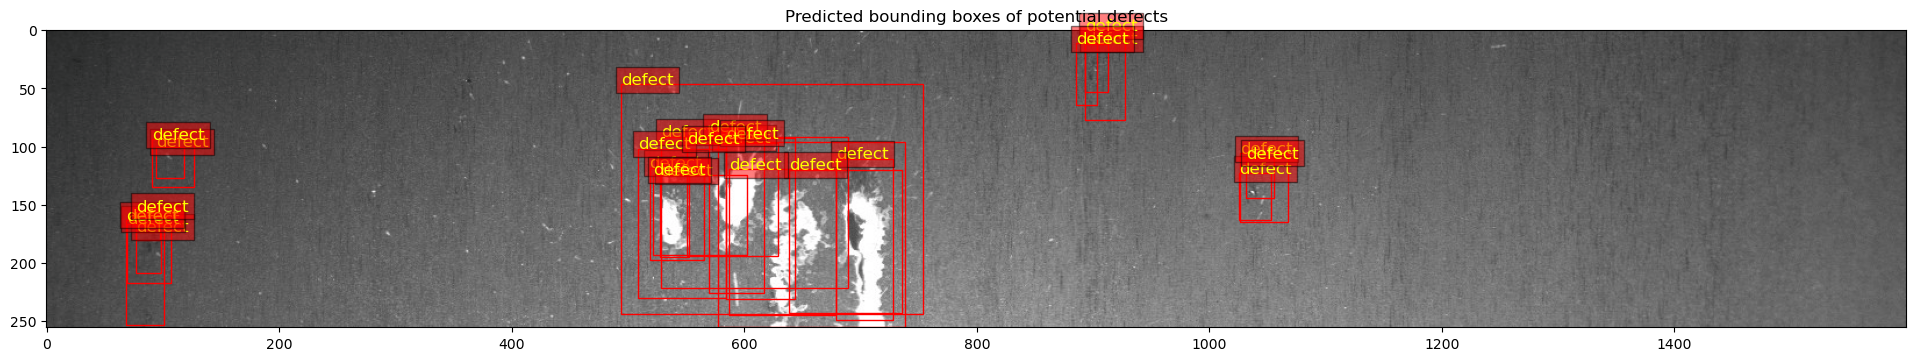

In [23]:
import torch
import torchvision.transforms.v2 as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
test_image_path = 'data/train_images/0bb3b11e1.jpg'

# Load and preprocess the test image
test_image = load_image(test_image_path)
test_image = test_image.to(device)

# Make predictions
with torch.no_grad():
    predictions = model([test_image])[0]

# Visualize the predictions
visualize_predictions(test_image, predictions, device)

In [19]:
#Save the model
torch.save(model.state_dict(), 'model_weights.pth')